<center>
<img src="https://i.ibb.co/ZVRt2f7/logo.png" alt="logo" border="0" width=800>

---

Eduard Larrañaga (ealarranaga@unal.edu.co)

---


---
# Neural Network modelling a Time Series.


The file 'ManchasSolares.txt' contains a dataset with the information of the monthly mean number of sunspots begining on january of 1749. We wan to train a neural network that predicts the mean number of sunspots using this information.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


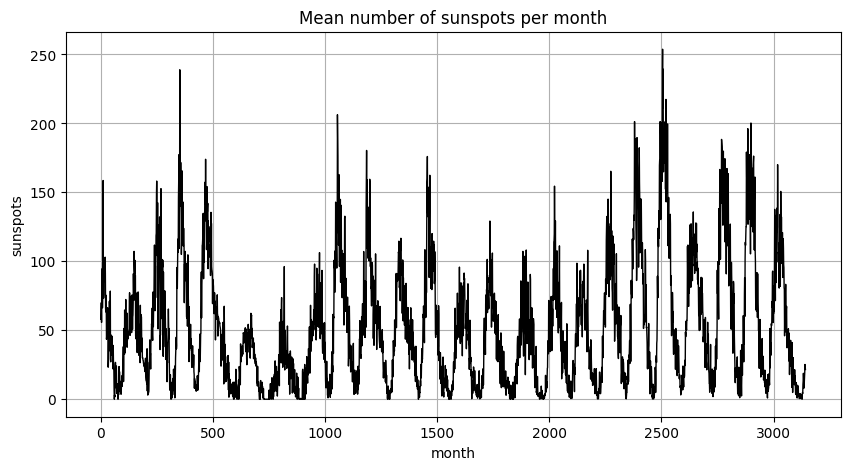

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

# Reading the data
time, series = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/Neural Networks/07. Time Series NN/ManchasSolares.txt', unpack=True)


plt.figure(figsize=(10,5))
plt.plot(time, series, color='black', linewidth=1)
plt.title('Mean number of sunspots per month')
plt.xlabel(r'month')
plt.ylabel(r'sunspots')
plt.grid()
plt.show()

---
## Preprocessing the data

In order to train the neural network, we will split the data set into training and test subsets. This time we will not split the set by taking randomly chosen data points. Instead, we will take the first 80% of the data to train the neural network and it will be used to predict the (future) behavior in the remaining 20% of the dataset. 

In [3]:
# split data into validation and training datasets
split_time = int(len(time)*0.8)

time_train = time[:split_time]
x_train = series[:split_time]

time_test = time[split_time:]
x_test = series[split_time:]

In [4]:
x_train.shape, x_test.shape

((2514,), (629,))

The idea is that the feature is a certain number of values in the series, while the label (or target) will be the next value. The number of values that we will treat as the feature will be called the **window size**. Hence, we said that we're taking a window of the data and training an ML model to predict the next value. 
For example, if we take our time series data 60 months at a time, we will use these 60 values as the feature and the next value is the label.

We will use the function [tensorflow.data.Dataset.from_tensor_slices()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) to create a `dataset`from the series. 

The method [dataset.window()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) creates the windows (subsets of elements of the input dataset). The first argument in the method determines the size of each window. The `shift` argument determines the number of inputs elements to shift to start the next window. 
Finally, the `drop_remainder` argument is set to `True`, so that the last windows should be dropped if their size is smaller than the chosen `size`.

The [dataset.flat_map()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) method is used to flatten the dataset of windows into a single dataset. The argument in this function is a function that takes the element from the dataset and returns a dataset. Then, the method chains together all the resulting datasets sequntially. Note that we use the [window.batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) method in the function. This method combines consecutive elements of the dataset into batches with a size given by its argument.

The method [dataset.shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) will randomly shuffle the elements of the dataset. Here the dataset fills a buffer with `buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

The final step in this data preparation function is to use  the [window.batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) function again and use the  method [.prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) which allows later elements to be prepared while the current element is being processed. This improves latency and throughput, at the cost of using additional memory to store prefetched elements.

---

First we will try to define the windows.

In [5]:
# Observe the initial structure of the series:
series

array([58. , 62.6, 70. , ..., 25.2, 23.5, 21.6])

In [6]:
# Create the windows witha given size and 
# the windows are flattened into a single dataset

# Note the shift of 1 between each window

window_size = 60

dt = tf.data.Dataset.from_tensor_slices(series)
dt = dt.window(window_size + 1, shift=1, drop_remainder=True)
dt = dt.flat_map(lambda window: window.batch(window_size + 1))
list(dt.as_numpy_iterator())[0:5]

[array([ 58. ,  62.6,  70. ,  55.7,  85. ,  83.5,  94.8,  66.3,  75.9,
         75.5, 158.6,  85.2,  73.3,  75.9,  89.2,  88.3,  90. , 100. ,
         85.4, 103. ,  91.2,  65.7,  63.3,  75.4,  70. ,  43.5,  45.3,
         56.4,  60.7,  50.7,  66.3,  59.8,  23.5,  23.2,  28.5,  44. ,
         35. ,  50. ,  71. ,  59.3,  59.7,  39.6,  78.4,  29.3,  27.1,
         46.6,  37.6,  40. ,  44. ,  32. ,  45.7,  38. ,  36. ,  31.7,
         22. ,  39. ,  28. ,  25. ,  20. ,   6.7,   0. ]),
 array([ 62.6,  70. ,  55.7,  85. ,  83.5,  94.8,  66.3,  75.9,  75.5,
        158.6,  85.2,  73.3,  75.9,  89.2,  88.3,  90. , 100. ,  85.4,
        103. ,  91.2,  65.7,  63.3,  75.4,  70. ,  43.5,  45.3,  56.4,
         60.7,  50.7,  66.3,  59.8,  23.5,  23.2,  28.5,  44. ,  35. ,
         50. ,  71. ,  59.3,  59.7,  39.6,  78.4,  29.3,  27.1,  46.6,
         37.6,  40. ,  44. ,  32. ,  45.7,  38. ,  36. ,  31.7,  22. ,
         39. ,  28. ,  25. ,  20. ,   6.7,   0. ,   3. ]),
 array([ 70. ,  55.7,  85. ,  

Note that each window has 61 elements. The first 60 are used as inputs while the last one is the corresponding label!!

Now, we will define a function that creates the windows and shuffle the information into batches.

In [7]:
# We define a function that turn a series into a dataset to train the 
# neural network

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
    # create the dataset from series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # slice the data up into appropriate windows
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # flatten into chunks with a size of window size + 1
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
    # batch into the selected batch_size and returned
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


# Parameters
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [ ]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
list(dataset.as_numpy_iterator())[0][0].shape

(32, 60)

In [ ]:
list(dataset.as_numpy_iterator())[0][0][0]

array([ 7.9, 10.1,  0. , 10.3,  1.9, 16.6,  5.5, 11.2, 18.3,  8.4, 15.3,
       27.8, 16.7, 14.3, 22.2, 12. ,  5.7, 23.8,  5.8, 14.9, 18.5,  2.3,
        8.1, 19.3, 14.5, 20.1, 19.2, 32.2, 26.2, 31.6,  9.8, 55.9, 35.5,
       47.2, 31.5, 33.5, 37.2, 65. , 26.3, 68.8, 73.7, 58.8, 44.3, 43.6,
       38.8, 23.2, 47.8, 56.4, 38.1, 29.9, 36.4, 57.9, 96.2, 26.4, 21.2,
       40. , 50. , 45. , 36.7, 25.6])

## The Neural Network

We will define a sequential neural network with an input layer with a number of neurons equal to the window size. Then, we use two hidden layers with 20 and 10 neurons and ReLU activation and an output layer with one layer. The loss function is the **M**ean **S**quared **E**rror (**MSE**) while the  optimizer will be [tf.keras.optimizers.SGD](https://keras.io/api/optimizers/sgd/). This algorithm uses gradient descent and momentum (which accelerates the gradient descent in the relevant direction and dampens oscillations).

In [54]:
# Two hidden layers and the output 
# Input shape is the size of window 

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation="relu", input_shape=[window_size]),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1)
    ])

model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])


history = model.fit(dataset,epochs=100)

model.summary()


Epoch 1/100
77/77 [==============================] - 4s 17ms/step - loss: 597.7070 - mean_absolute_error: 17.2743
Epoch 2/100
77/77 [==============================] - 1s 13ms/step - loss: 410.2188 - mean_absolute_error: 14.5333
Epoch 3/100
77/77 [==============================] - 1s 7ms/step - loss: 353.2163 - mean_absolute_error: 13.4703
Epoch 4/100
77/77 [==============================] - 1s 8ms/step - loss: 347.3849 - mean_absolute_error: 13.2618
Epoch 5/100
77/77 [==============================] - 1s 12ms/step - loss: 315.9636 - mean_absolute_error: 12.5168
Epoch 6/100
77/77 [==============================] - 1s 14ms/step - loss: 308.3477 - mean_absolute_error: 12.5812
Epoch 7/100
77/77 [==============================] - 1s 8ms/step - loss: 295.6767 - mean_absolute_error: 12.3204
Epoch 8/100
77/77 [==============================] - 1s 8ms/step - loss: 273.9775 - mean_absolute_error: 11.8372
Epoch 9/100
77/77 [==============================] - 1s 6ms/step - loss: 280.3784 - mean_abs

In [ ]:
#model.save('/content/drive/MyDrive/Colab Notebooks/Neural Networks/07. Time Series NN/model01')

In [ ]:
recovered_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Neural Networks/07. Time Series NN/model01')

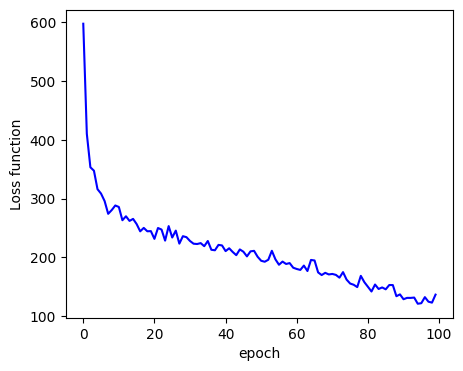

In [55]:
loss = history.history['loss']
epochs = range(len(loss))

plt.figure(figsize=(5,4))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.xlabel('epoch')
plt.ylabel('Loss function')
plt.show()

In [51]:
forecast=[]

for time in range(split_time - window_size, len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis], verbose=False))

results = np.array(forecast)[:, 0, 0]

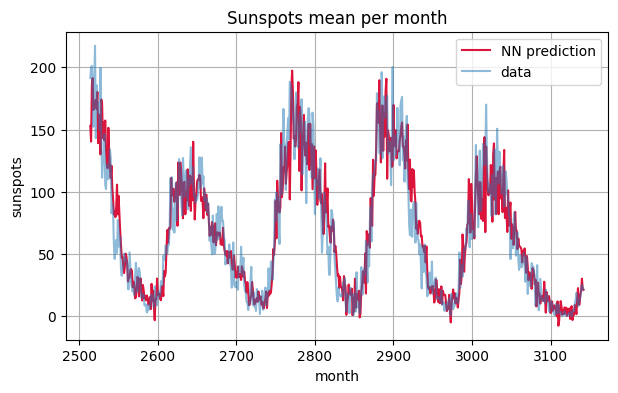

In [52]:
plt.figure(figsize=(7, 4))
plt.plot(time_test, results, c = 'crimson', label='NN prediction')
plt.plot(time_test, x_test, label='data', alpha=0.5)

plt.title('Sunspots mean per month')
plt.xlabel(r'month')
plt.ylabel(r'sunspots')
plt.grid()
plt.legend()
plt.show()

In order to measure the accuracy of the algorithm, we will use the [**M**ean **A**bsolute **E**rror](https://keras.io/api/metrics/regression_metrics/#meanabsoluteerror-class) (**MAE**) metric  

In [ ]:
tf.keras.metrics.mean_absolute_error(x_test, results).numpy()

13.9455595